**This notebook contains the code for visualization for our predictions on the test dataset**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle

In [3]:
import os
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import shutil
import cv2
import matplotlib.pyplot as plt

In [ ]:
!unzip /content/drive/MyDrive/my_test.zip

In [4]:
meta_test=pd.read_csv('/content/drive/MyDrive/meta_test.csv')

**Cloning the yolo-v5 repository**

In [5]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9909, done.
remote: Total 9909 (delta 0), reused 0 (delta 0), pack-reused 9909
Receiving objects: 100% (9909/9909), 10.09 MiB | 23.74 MiB/s, done.
Resolving deltas: 100% (6896/6896), done.


**Inferencing by using the ensemble of weights**

In [8]:
!python /content/yolov5/detect.py --weights '/content/drive/MyDrive/best.pt' '/content/drive/MyDrive/best (1).pt' '/content/drive/MyDrive/best (3).pt' '/content/drive/MyDrive/best (4).pt' '/content/drive/MyDrive/best (5).pt' --source /content/resized_test_data --img 256  --iou-thres 0.5 --conf 0.2 --max-det 5 --save-txt --save-conf

detect: weights=['/content/drive/MyDrive/best.pt', '/content/drive/MyDrive/best (1).pt', '/content/drive/MyDrive/best (3).pt', '/content/drive/MyDrive/best (4).pt', '/content/drive/MyDrive/best (5).pt'], source=/content/resized_test_data, imgsz=[256, 256], conf_thres=0.2, iou_thres=0.5, max_det=5, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-30-gfee83c1 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients
Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients
Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients
Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients
Fusing layers... 


In [10]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

**Loading the vgg16 model for getting the predictions at study level**

In [11]:
top_model=load_model('/content/drive/MyDrive/top_model.h5')

In [12]:
test_datagen=ImageDataGenerator(rescale=1/255)

In [9]:
meta_test_sorted=meta_test.sort_values(by='image_id')

**This code helps us to get the original co-ordiantes from the bounding box co-ordinates**

In [18]:
img_level_pred={}
img_level_predictions=[]
img_level_id=[]
for img_test in tqdm(os.listdir('resized_test_data')):
  img_level_readings=[]
  for img_txt in os.listdir('/content/yolov5/runs/detect/exp2/labels'):
    if img_txt.split('.')[0]==img_test.split('.')[0]:
      dim_0= meta_test_sorted[meta_test_sorted['image_id']==img_txt.split('.')[0]]['dim0']
      dim_1= meta_test_sorted[meta_test_sorted['image_id']==img_txt.split('.')[0]]['dim1']

      scale_fact_x=dim_1/256
      scale_fact_y=dim_0/256

      with open('/content/yolov5/runs/detect/exp2/labels/'+ img_txt) as f:
        for line in f:
          b=line.strip('\n').split(' ')
          bb_conf_coord=[]
          for num in b:
            bb_conf_coord.append(eval(num))
          conf_box=bb_conf_coord[5]
          xc,yc=int(bb_conf_coord[1]*256),int(bb_conf_coord[2]*256)
          w,h=int(bb_conf_coord[3]*256),int(bb_conf_coord[4]*256)
          #print(xc,yc,w,h)
          xmin = xc - (w/2)
          ymin = yc - (h/2)
          xmax = xc + (w/2)
          ymax = yc + (h/2)

          xmin=int(xmin)
          xmax=int(xmax)
          ymin=int(ymin)
          ymax=int(ymax)

          #img_level_readings.append('opacity'+ ' ' + str(conf_box) + ' ' + str(xmin) + ' ' + str(ymin) + ' ' + str(xmax) + ' ' + str(ymax))
          img_level_readings.append([conf_box,xmin,ymin,xmax,ymax])
  #print(img_level_readings)
  if len(img_level_readings)==0:

    img_level_readings.append([])

  #img_level_predictions.append(' '.join(img_level_readings))
  img_level_predictions.append(img_level_readings)
  img_level_id.append(img_test.split('.')[0]+'_image')
img_level_pred.update({'id':img_level_id,'PredictionString':img_level_predictions})

100%|██████████| 1263/1263 [00:03<00:00, 356.37it/s]


In [19]:
img_level_pred_df=pd.DataFrame(img_level_pred)

**Predictions at image level from yolo-v5 model**

In [20]:
img_level_pred_df.head()

,id,PredictionString
0,7b5d82423dec_image,"[[0.236673, 142, 55, 202, 165]]"
1,35d6801ca10a_image,"[[0.275916, 31, 48, 87, 174], [0.55724, 27, 11..."
2,b168e230f3f5_image,"[[0.300023, 51, 137, 107, 210], [0.359795, 147..."
3,7bf91ffc125c_image,[[]]
4,f99f9714b911_image,"[[0.260967, 11, 110, 82, 182], [0.457736, 16, ..."


**This code helps us to visualize the predictions made by yolo-v5 model and vgg-16 model**

Found 1 validated image filenames.
Class: atypical


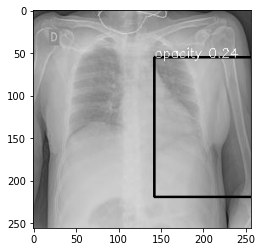

Found 1 validated image filenames.
Class: atypical


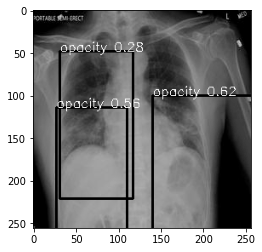

Found 1 validated image filenames.
Class: atypical


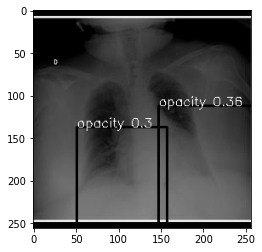

Found 1 validated image filenames.
Class: indeterminate


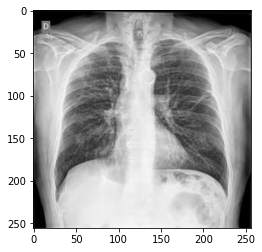

Found 1 validated image filenames.
Class: atypical


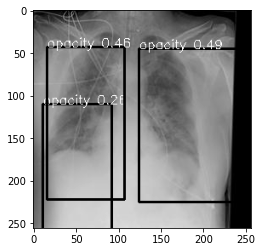

Found 1 validated image filenames.
Class: indeterminate


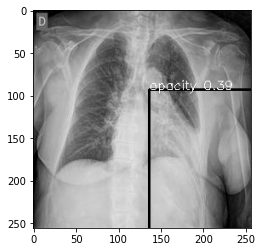

Found 1 validated image filenames.
Class: atypical


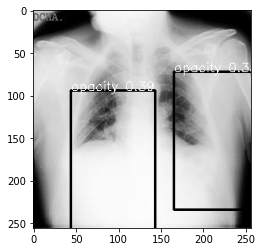

In [30]:
count=0
for ind in img_level_pred_df.index:
  test_path=[]
  test_path.append('resized_test_data/'+img_level_pred_df['id'][ind].replace('_image','.jpg'))
  test_df=pd.DataFrame({'path':test_path})
  test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,x_col='path',target_size=(256,256),batch_size=1,class_mode=None,shuffle=False)
  prediction=top_model.predict(test_generator)
  test_prediction=np.argmax(prediction,axis=1)
  if test_prediction[0]==0:
    print('Class:','negative')
  elif test_prediction[0]==1:
    print('Class:','typical')
  elif test_prediction[0]==2:
    print('Class:','indeterminate')
  elif test_prediction[0]==3:
    print('Class:','atypical')
  if len(img_level_pred_df['PredictionString'][ind][0])>0:
    img_name=img_level_pred_df['id'][ind].replace('_image','.jpg')
    img=np.array(Image.open('resized_test_data/'+img_name))
    for j in range(len(img_level_pred_df['PredictionString'][ind])):
      image=cv2.rectangle(img,(int(img_level_pred_df['PredictionString'][ind][j][1]),int(img_level_pred_df['PredictionString'][ind][j][2]),int(img_level_pred_df['PredictionString'][ind][j][3]),int(img_level_pred_df['PredictionString'][ind][j][4])),(0,255,0),2)
      cv2.putText(image,'opacity '+str(np.round(img_level_pred_df['PredictionString'][ind][j][0],2)),(int(img_level_pred_df['PredictionString'][ind][j][1]),int(img_level_pred_df['PredictionString'][ind][j][2])),cv2.FONT_HERSHEY_SIMPLEX,0.5,color=(255,0,0),thickness=1)
    count+=1
    plt.imshow(image,cmap='gray')
    plt.show()
    if count>5:
      break

  else:
    img_name=img_level_pred_df['id'][ind].replace('_image','.jpg')
    img=np.array(Image.open('resized_test_data/'+img_name))
    plt.imshow(img,cmap='gray')
    plt.show()